#**Assessed Exercice-Zineb Senane** 

# Data preparation

### A. (code) Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the original training set. [3]

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import scipy.linalg
import scipy.stats
import warnings
from tqdm.notebook import tqdm
from jax import random
from functools import partial
from typing import NamedTuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import roc_auc_score

color = sns.color_palette()



In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c santander-customer-transaction-prediction
! unzip santander-customer-transaction-prediction.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
santander-customer-transaction-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  santander-customer-transaction-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
#Download the dataset
df = pd.read_csv("train.csv")
df_features = df.drop(['target','ID_code'], axis=1)

In [4]:
#Dimensionality
print("The number of samples:",len(df))
print("The number of columns :",len(df.columns),",including the target and the index")


The number of samples: 200000
The number of columns : 202 ,including the target and the index


Imbalanced Dataset :  10.049 % of positive targets


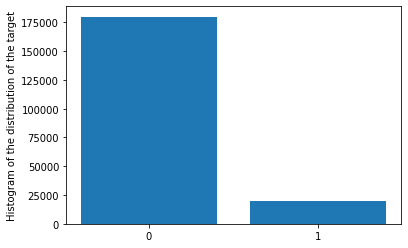

In [5]:
target_1 = len(df[df['target'] == 1])
target_0 = len(df[df['target'] == 0])

classes = ['Target 0','Target 1']

plt.ylabel('Histogram of the distribution of the target')
plt.bar([0,1],[target_0,target_1],width = 0.8,tick_label = [0,1])


frequency_of_1 = target_1/len(df)

print("Imbalanced Dataset : ", frequency_of_1*100, "% of positive targets")

In [6]:
target = df.target #Creating the dataframe of the target
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.5)
#New train and test dataset
print("######## New Training and Testing datasets ##########")

print('The shape of X_train is ' , X_train.shape)
print('The shape of X_test is ' , X_test.shape)

######## New Training and Testing datasets ##########
The shape of X_train is  (100000, 200)
The shape of X_test is  (100000, 200)


In [7]:
y_train.describe()

count    100000.000000
mean          0.100880
std           0.301171
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [8]:
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

### B. (text) Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis. [7]

As we can see above on the barplot (10% of positive targets), We are dealing with imbalanced data. We have almost 180000 samples that belong to the class with target 0 and less than 25000 samples to the class labeled with 1. This will affect the performance of our models: biased learning, and poorer generalization over the minor class (1).
Moreover, this dataset is highly dimensioned compared to the one we used in the labs (200 vs 2). Overall, the convergence and the amelioration of Bayesian models' performance will be difficult.

To help the models learn correctly in the next parts, we need some preprocessing. I used an undersampling method (reducing the number of negative samples in the dataset). I preferred the undersampling regardless of the oversampling because the oversampling may increase the likelihood of occurring overfitting since it makes exact copies of the minority class examples.

# 1.Bayesian linear regression 

### A. (code) Implement Bayesian linear regression (you should already have an implementation from the lab sessions) [10]

In [9]:
##All the function needed to do bayeian linear regression from the first lab

#Lognormal
def lognormal(x, mu, var):
    return np.log((1/np.sqrt(2*np.pi*var)))-((x-mu)**2)/(2*var)

#Log gaussian likelihood
def gaussian_loglik(y, y_tilde, sn2):
    return np.sum(lognormal(y,y_tilde,sn2))

#Compute the posterior
def compute_posterior(X, y, sw2, sn2):
    inv_cov=(1/sn2)*np.dot(X.T,X)+(1/sw2)*np.ones((X.shape[1],X.shape[1]))
    w_posterior_cov=np.linalg.inv(inv_cov)
    w_posterior_mean=(1/sn2)*np.dot(w_posterior_cov,np.dot(X.T,y))
    return w_posterior_mean, w_posterior_cov


#Compute the predictive distribution
def compute_predictive(X_test, w_mean, w_cov, sn2):
    def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
        yt_i_mean = np.dot(xt_i.T,w_mean)
        yt_i_var = sn2+np.dot(np.dot(xt_i.T,w_cov),xt_i)
        return yt_i_mean, yt_i_var

    yt_mean, yt_var = np.zeros(len(X_test)), np.zeros(len(X_test))
    for i, xt_i in enumerate(X_test):  # Loop on all the points
        yt_mean[i], yt_var[i] = _compute_predictive_single_point(
            xt_i, w_mean, w_cov, sn2
        )

    return yt_mean, yt_var


#Sample from the predictive distribution
def sample(X_test, w_mean, w_cov, sn2,N):
    def _sample_single(X_test, w_mean, w_cov, sn2):
        w_tilde = np.random.multivariate_normal(w_mean,w_cov)
        y_sample=np.dot(X_test,w_tilde)+np.random.normal(0, sn2, np.dot(X_test,w_tilde).shape)
        return y_sample
    
    samples = np.zeros((N, len(X_test)))
    for i in range(N):
        samples[i] = _sample_single(X_test, w_mean, w_cov, sn2)
    return samples

#Function to return the mean, variance and the predict the target 
def bayesian_linear_regression(X_train, Y_train, X_test, sn2, sw2,N):
    w_posterior_mean, w_posterior_cov = compute_posterior(X_train,Y_train,sw2,sn2) 
    y_mean, y_var = compute_predictive(X_test,w_posterior_mean,w_posterior_cov,sn2)  
    samples = sample(X_test,w_posterior_mean,w_posterior_cov,sn2,N)  
    return y_mean, y_var, samples


### B. (text) Describe any pre-processing that you suggest for this data [5]

The important steps to preprocess a dataset are resumed as following:

- if the dataset contains missing values , we should compute the mean of the corresponding column and fill the missing values  appearing in this columN  with its mean. 
- Balance the data if we have a major and minor class.
- Compute the features importance , such that we drop the ones which have low variance. 
- We perform the scaling  in case where the difference between the max value and the min value of a given feature is so high. 

In our case, the most effective preprocessing to do is balancing the data as mentioned before. To avoide the NaN values in the computations performed by Bayesian models, I prefer also to scale the data by using a standard scaler.

**The only preprocessing I suggest, is to normalize the data in hand. Since the correlation matrix computed in the Data Analysis part proves that all tha columns are uncorrelated and all the features are equally important. performing PCA on the data or any feature selection method will be useless.**

#### Balancing the data



In [10]:
def balance_data(df,type):
  if type=='Under':
    threshold = 0.15
    data = df[(np.random.rand(df.shape[0]) < threshold) | (df["target"] == 1)]

    ones = len(data[data['target'] == 1])
    zeros = len(data[data['target'] == 0])

    classes = ['Target 0','Target 1']

    plt.bar(classes,[zeros,ones],color='blue',edgecolor='black')
    plt.xticks(classes)

    plt.bar([0,1],[zeros,ones])
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title("Imbalance of the two classes")
    plt.show()

    class_imbalance = ones/len(data)

    print("Class Imbalance : ", class_imbalance*100, "% of positive targets")
  if type=='Over':
    # class count
    class_count_0, class_count_1 = df['target'].value_counts()

    # Separate class
    class_0 = df[df['target'] == 0]
    class_1 = df[df['target'] == 1]# print the shape of the class
    print('class 0:', class_0.shape)
    print('class 1:', class_1.shape)
    class_1_over = class_1.sample(class_count_0, replace=True)
    data = pd.concat([class_1_over, class_0], axis=0)

    print("total class of 1 and 0:",data['target'].value_counts())# plot the count after under-sampeling
    data['target'].value_counts().plot(kind='bar', title='count (target)')

  #ASSIGNMENT
  features = data.drop('target', axis=1)
  features = features.drop('ID_code' , axis=1)
  #Creating the dataframe of the target
  target = data.target
  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5)
  #TRANSFORMATION TO ARRAYS
  X_train=X_train.values
  X_test=X_test.values
  Y_train=y_train.values
  Y_test=y_test.values


  return X_train, X_test, Y_train, Y_test

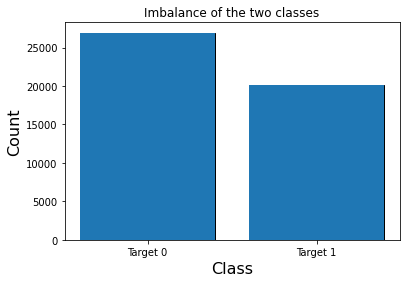

Class Imbalance :  42.73442483521156 % of positive targets


In [11]:
new_X_train, new_X_test, new_Y_train, new_Y_test=balance_data(df,'Under')

### C. (code) Treat class labels as continuous and apply regression to the training data. Also, calculate and report the posterior variance of the weights [10]

###### Scaling the data

In [12]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
new_X_train=sc.fit_transform(new_X_train)
new_X_test=sc.transform(new_X_test)

#### With imbalanced Data

In [13]:
w_posterior_mean,w_posterior_cov=compute_posterior(X_train, y_train, 1, 1)
y_mean, y_var, samples=bayesian_linear_regression(X_train, y_train, X_test, 1, 1,5)


In [14]:
print("The posterior mean")
print(w_posterior_mean)

The posterior mean
[ 1.25011398e-02  1.20703023e-02  1.32371081e-02  1.66143950e-03
  4.63206097e-03  7.40700230e-03  1.51422438e-02 -5.88664016e-04
  2.62301303e-03 -1.02357588e-02 -8.70376946e-05  4.73849966e-03
 -1.77845388e-02 -1.35926040e-02 -1.55543571e-03  5.04392917e-03
  4.31775734e-04  8.95235927e-04  9.84127028e-03  2.36515097e-03
 -5.16029837e-03 -1.53442029e-02  1.42421690e-02 -6.77285654e-03
  7.73596404e-03  2.88719219e-03  1.47091553e-02  2.56762545e-04
 -6.31126081e-03  1.80530907e-03  9.76827467e-04 -6.89651228e-03
  8.51450709e-03 -1.15062208e-02 -1.22022702e-02  9.80936961e-03
 -8.89814249e-03  1.89923916e-03  2.55812321e-04 -6.33854318e-04
  1.29952106e-02  4.97437239e-04 -2.80263049e-03 -6.31553755e-03
 -1.25888914e-02 -5.02679507e-03  2.58915579e-03  2.80171304e-03
  7.77404416e-03  7.59709443e-03 -3.29694377e-03  6.07765258e-03
  7.44894024e-03  1.63897914e-02 -4.22099625e-03  4.70890891e-03
 -8.21274784e-03 -4.73664756e-03 -7.57087448e-03 -2.22776922e-03
  2.93

In [15]:
print("the posterior covariance")
print(w_posterior_cov)

the posterior covariance
[[ 1.00285910e-05  4.83134201e-08 -5.35083830e-08 ... -4.33935455e-08
   6.13136285e-08 -1.43240537e-08]
 [ 4.83134201e-08  1.00250898e-05 -1.42336975e-08 ...  2.67923830e-08
   3.75254209e-08 -4.03738071e-09]
 [-5.35083830e-08 -1.42336975e-08  1.00225477e-05 ...  1.83128449e-08
   3.18639209e-08 -4.54193137e-08]
 ...
 [-4.33935455e-08  2.67923830e-08  1.83128449e-08 ...  1.00205250e-05
   1.95223782e-08 -6.02930506e-08]
 [ 6.13136285e-08  3.75254209e-08  3.18639209e-08 ...  1.95223782e-08
   1.00241342e-05  4.22591178e-08]
 [-1.43240537e-08 -4.03738071e-09 -4.54193137e-08 ... -6.02930506e-08
   4.22591178e-08  1.00200654e-05]]


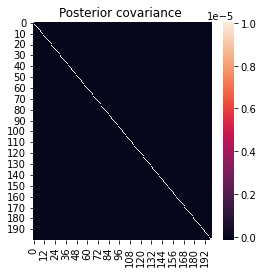

In [16]:
plt.figure(figsize=(4,4))
sns.heatmap(w_posterior_cov)
plt.title('Posterior covariance ')
plt.show()

#### With balanced Data

In [17]:
w_posterior_meanB,w_posterior_covB=compute_posterior(new_X_train, new_Y_train, 1, 1)
y_meanB, y_varB, samplesB=bayesian_linear_regression(new_X_train, new_Y_train, new_X_test, 1, 1,5)

In [18]:
print("The posterior mean for the balanced data")
print(w_posterior_meanB)

The posterior mean for the balanced data
[ 2.46331673e-02  2.29109474e-02  2.68335094e-02  7.29186724e-03
  6.63296062e-03  1.74727744e-02  3.45250965e-02 -4.73285231e-03
  8.73127646e-03 -2.06563081e-02 -1.79450361e-03  1.46656842e-02
 -3.20349505e-02 -2.64226880e-02 -1.59550936e-03  9.18963804e-03
  3.69137958e-03 -6.18618577e-04  2.09497006e-02  6.13324650e-03
 -1.27181859e-02 -2.75195446e-02  2.93690837e-02 -1.62715028e-02
  1.11282364e-02  4.19902713e-03  2.85526634e-02  1.45637171e-03
 -1.43210282e-02  5.72601250e-03  7.02227485e-04 -1.60505102e-02
  1.72351664e-02 -2.51461943e-02 -2.53763073e-02  1.87694033e-02
 -1.96426345e-02  4.10886420e-03  2.77433609e-03  4.00966222e-03
  2.64133112e-02 -2.32778198e-03 -1.34844635e-03 -1.62303572e-02
 -2.52837042e-02 -1.18409302e-02  1.69275224e-03  2.84574149e-03
  1.61979001e-02  1.56846934e-02 -5.03161060e-03  1.23759373e-02
  1.85183404e-02  3.07264898e-02 -9.26955210e-03  1.18547611e-02
 -2.05377775e-02 -3.54887601e-03 -1.13234831e-02 

In [19]:
print("The posterior covariance of the balanced data")
print(w_posterior_covB)

The posterior covariance of the balanced data
[[ 4.29814577e-05  1.23847339e-08 -3.91170360e-07 ...  2.09360717e-07
  -1.53445386e-07 -2.72360417e-07]
 [ 1.23847339e-08  4.29657894e-05 -9.94898498e-08 ...  3.55376668e-07
   5.05991252e-07 -5.41947781e-07]
 [-3.91170360e-07 -9.94898498e-08  4.30479745e-05 ...  1.70095532e-07
  -1.95132212e-07  1.16083598e-07]
 ...
 [ 2.09360717e-07  3.55376668e-07  1.70095532e-07 ...  4.29846317e-05
   9.35317651e-09 -2.20210409e-07]
 [-1.53445386e-07  5.05991252e-07 -1.95132212e-07 ...  9.35317651e-09
   4.29711129e-05  1.17178919e-07]
 [-2.72360417e-07 -5.41947781e-07  1.16083598e-07 ... -2.20210409e-07
   1.17178919e-07  4.30106426e-05]]


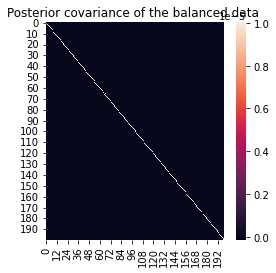

In [20]:
plt.figure(figsize=(4,4))
sns.heatmap(w_posterior_cov)
plt.title('Posterior covariance of the balanced data ')
plt.show()

 **
**We observe that most of the weights have a variance around 1e-5, and there is very little covariance between the different weights (1e-8).**

To discretise the output labels we have to choose a threshold that will separate the continuous values, above the threshold; a value will be considered to have a label of "1", otherwise "0".

Many solutions exist for choosing a threshold; since we have an unbalanced dataset, we will choose the threshold so it separate the dataset to 90% elements of label "0" and 10% will be left for the label "1", I will use also an optimal way that chooses the threshold which uses the ROC-curve but it could be considered as cheating, since we need the labels ytst; but it's the optimal way to separate the continuous labels.

To compute the confusion matrix and to report the accuracy, we will use the built-in functions within the sklearn library.**

### D. (text) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy [5]

To discretize the predicted labels, a naive way is to fix a threshold (the mean for example). Hence, we assign the predicted labels bigger than the threshold class 1, and 0 to the others. However, this will not work well with imbalanced data. a solution can be to set a list of different threshold and try to do discretizing and choose the one that minimizes a given loss or increase a performance metric such as Accuracy or AUC. I used the sensitivity, specificity, and AUC scores, which are better than simple accuracy to control model performance on imbalanced datasets. Indeed the accuracy of a naive model predicting only 0 on a 90% in our case but the AUC is only 0.5.

In [21]:
def discreticize(y_predicted,treshold):
    y_discretized = []
    for i in range(len(y_predicted)):
        if(y_predicted[i] < treshold):
            y_discretized.append(0)
        else:
            y_discretized.append(1)
    return y_discretized


def treshold(tresholdlist,y_predicted,y):
    result_list = []
    tre=0
    AUC_score=0
    for treshold in tresholdlist: 
          discretized_target=np.zeros(y_predicted.shape)
          discretized_target[y_predicted> treshold] = 1
          discretized_target[y_predicted<= treshold]= 0
          print(discretized_target)
          score =  roc_auc_score(y, discretized_target)
          result_list.append(score)
          if AUC_score<score:
            tre=treshold
            AUC_score=score

    plt.xlabel('Threshold')
    plt.ylabel('AUC score')
    plt.title('AUC score against threshold value')
    plt.plot(tresholdlist , result_list)
    print("Treshold for the highest score is : ", tre)


In [22]:
def result_analysis(y_predicted,y):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_predicted)):
        if(y_predicted[i] == 1 and y[i] == 1):
            TP += 1
        if(y_predicted[i] == 0 and y[i] == 1):
            FN += 1
        if(y_predicted[i] == 1 and y[i] == 0):
            FP += 1
        else:
            TN += 1
            
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Sensitivity, hit rate, recall, or true positive rate
    se = TP / (TP + FN )
    # Specificity or true negative rate
    sp = TN / (TN + FP )

    error_rate = 1 - accuracy
        
    auc_score = roc_auc_score(y, y_predicted)
        
    return TP, TN, FP, FN, accuracy, error_rate, se, sp, auc_score


In [23]:
def evaluate(y_predicted,y):
    
    TP, TN, FP, FN, accuracy, error_rate, se, sp, auc = result_analysis(y_predicted,y)
            
    confusion_matrix = [[FP,TP],[TN,FN]]
    df_cm = pd.DataFrame(confusion_matrix, [1,0], [0,1])
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title("Confusion Matrix ")
    
    plt.show()
    
    print("accuracy : ",accuracy)
    print("error rate : ", error_rate)
    print("Sensitivity : ", se)
    print("Specificity : ", sp)
    print("AUC : ", auc)

#### Imbalanced Data

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
Treshold for the highest score is :  0.1


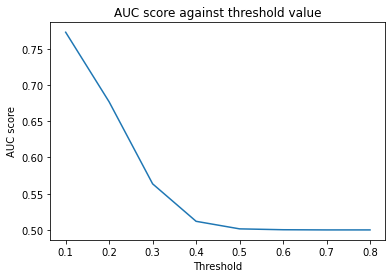

In [24]:
treshold([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],y_mean,y_test)

In [25]:
threshold = np.sort(y_mean)[90800]
threshold

0.17229632442397116

In [26]:
def evaluate_treshold(t,y_predicted,y):
  misclassified=0
  well_classified = 0
  diff = np.array(discreticize(y_predicted,t))-np.array(y)
  for i in range(len(y)):
     if diff[i]==0:
        well_classified+=1
     else:
        misclassified+=1
  print("Correct label", well_classified,"/ Bad label", misclassified)

In [27]:
evaluate_treshold(0.17,y_mean,y_test)

Correct label 90104 / Bad label 9896


In [28]:
evaluate_treshold(0.1,y_mean,y_test)

Correct label 83288 / Bad label 16712


As we can see, since we have an unbalanced dataset, using a threshold that separates the dataset to ~90% elements labeled with 0 and ~10% will be left for the label "1" gives better classification (less misclassified samples). However this should not be useful when we deal with unseen and unlabeled samples as testing dataset. My goal was just to optimize the number of good classified points, so I used the ROC curve to find a good treshold.

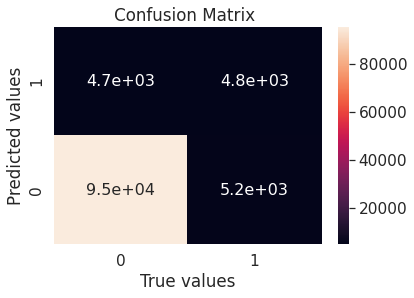

accuracy :  0.9100445414053268
error rate :  0.08995545859467324
Sensitivity :  0.47872127872127873
Specificity :  0.95322
AUC :  0.7133688624965433


In [29]:
y_predicted_BLiR=discreticize(y_mean,0.17)
evaluate(y_predicted_BLiR,y_test)

#### Balanced Data

In [30]:
count=0
for i in range(len(new_Y_train)):
   if new_Y_train[i]==0:
      count+=1
count

13474

Here again we used the same trick mentioned before to set the treshold (~10000 samples labeled with 1 and ~13500 samples labeled with 0), and it works quite well. 

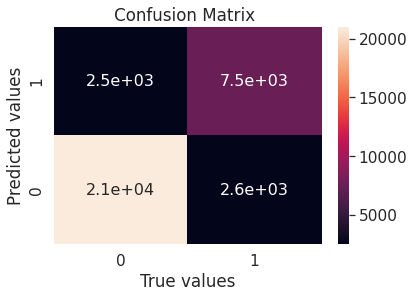

accuracy :  0.8492195877516978
error rate :  0.1507804122483022
Sensitivity :  0.7462463955453913
Specificity :  0.8932596215181798
AUC :  0.7798701141049886


In [31]:
new_y_predicted_BLiR = discreticize(y_meanB,np.sort(y_meanB)[13500])
evaluate(new_y_predicted_BLiR,new_Y_test)

# 2.Logistic linear regression

Note: Functions implemented in the logscale

### A. (code) The goal is to implement a Bayesian logistic regression classifier; assume a Gaussian prior on the parameters. As a first step, implement a Markov chain Monte Carlo inference algorithm to infer parameters (you should already have an implementation of the Metropolis-Hastings algorithm from the lab sessions). [10]

In [32]:
def logistic(z):
    return 1/(1+np.exp(-z))
def bernoulli_density(y, p):
  return np.where(y==1,np.log(p),np.log(1-p))
def bernoulli_likelihood(y,p):
  return np.sum(bernoulli_density(y,p))
def gaussian_density(x, mean=0, var=1):
    return - 0.5 * np.log(2 * np.pi * var) - 0.5 * (x - mean)**2 / var 
###################
def logprior(x,sigma):
  first_term = 1/((2*np.pi) * np.linalg.det(sigma)**(1/2)) 
  second_term = np.exp(-1/2 * x.T @ np.linalg.inv(sigma) @ x)
  value = np.log(first_term * second_term + 1e-10)
  return value
##################
def logposterior(w, X, y):
  # Computing the log liklehood
 
  lik=bernoulli_likelihood(y,logistic(np.matmul(w,X.T)))
  #Computing the prior 
  prior=np.sum(gaussian_density(w))
  return lik+prior

def rw_mh_step(X,y,w_prev, step_size):
    ws_t = np.random.multivariate_normal(mean=np.zeros(len(w_prev)), cov = np.eye(len(w_prev)))
    ws_t = ws_t * step_size + w_prev
    ratio = np.exp(logposterior(ws_t, X, y) - logposterior(w_prev, X, y))
    if ratio >= 1 or ratio >= np.random.uniform(0, 1):
      w_next = ws_t
    else:
      w_next = w_prev   
    return w_next 

def run_sampling(X,y,w, n_samples, step_size=1):
    w = np.atleast_1d(w)
    samples = np.empty((n_samples, *w.shape))
    for i in range(n_samples):
        w = rw_mh_step(X,y,w, step_size)
        samples[i] = w
    return samples



#### Assessing convergence of MCMC

In an attempt to assuage concerns of poor convergence, we typically run multiple independent chains to see if the obtained distribution is similar across chains. At convergence, the chains will have mixed, so that the distribution of the simulations
between and within chains will be identical, and the ratio $\hat R$ should equal 1. If $\hat R$
is greater than 1, this implies that the chains have not fully mixed and that further simulation might increase the precision of inferences. In practice we typically go until $\hat R$ is less than 1.1/1.05 for all parameters.

In [33]:
def run_multiple_chains(X,y,w_init, n_chains, n_samples, step_size=0.5):
    w_init = np.atleast_1d(w_init)
    samples = np.zeros((n_chains, n_samples, *w_init.shape))
    # @@ COMPLETE @@ #
    for i in range(n_chains):
      samples[i] = run_sampling(X,y,w_init, n_samples, step_size)
    return samples

def compute_rhat(samples):
    """Compute the rhat statistics from samples. Samples needs to be a tensor
    with dimensions [num_of_chain, num_of_samples, num_of_variables]."""

    def _rhat_base(ary):
        """Compute the rhat for a 2d array."""
        _, num_samples = ary.shape

        # Calculate chain mean
        chain_mean = np.mean(ary, axis=1)
        # Calculate chain variance
        chain_var = np.var(ary, axis=1, ddof=1)
        # Calculate between-chain variance
        between_chain_variance = num_samples * np.var(chain_mean, axis=None, ddof=1)
        # Calculate within-chain variance
        within_chain_variance = np.mean(chain_var)
        # Estimate of marginal posterior variance
        rhat_value = np.sqrt(
            (between_chain_variance / within_chain_variance + num_samples - 1)
            / (num_samples)
        )
        return rhat_value


### B. (code) Implement the variational approximation we studied in the course to obtain an approximation to the posterior over model parameters (you should already have an implementation of the from the lab sessions). [10]

We will this time use variational inference. We used the simplest basic prior and posterior distributions that have a diagonal covariance matrix.


In [34]:

def predict_y(sample_fn, q_params, Xt, rng, Nmc=10): 
    def predict_y_single(rng):
        w = sample_fn(rng, q_params)
        yp = model(w, Xt)
        return yp
    rng = jax.random.split(rng, Nmc)
    Xt = jnp.atleast_1d(Xt)
    yp = jax.vmap(predict_y_single)(rng)
    yp = np.mean(yp, axis=0) 
    return yp

In [35]:
def bernoulli_density(y, p):
    return jnp.log(jnp.where(y==1,p,1-p)+1e-10)# @@ COMPLETE @@ #

class GaussianDiagonal(NamedTuple):
    mean: jnp.array
    log_var: jnp.array

def sample_gaussian_diagonal(rng, params):
    mean, log_var = params
    eps = jax.random.normal(key=rng, shape=log_var.shape) 
    return mean+jnp.sqrt(jnp.exp(log_var))*eps# @@ COMPLETE @@ #
   

def kl_diag_diag(q_params, p_params):
    assert isinstance(q_params, GaussianDiagonal)
    assert isinstance(p_params, GaussianDiagonal)
    mean_q, log_var_q = q_params
    mean_p, log_var_p = p_params
    # @@ COMPLETE @@ #
    kl=log_var_p-log_var_q+(jnp.exp(log_var_q)+jnp.power(mean_q-mean_p,2))/jnp.exp(log_var_p)-1
    kl=jnp.sum(kl)/2
    return kl
def logistic(z):
    return 1/(1+jnp.exp(-z))# @@ COMPLETE @@ #


def model(w, X):
    return logistic(jnp.dot(X,w.T))# @@ COMPLETE @@ #

def create_elbo_fn(sample_fn, likelihood_fn, kl_divergence_fn):
    """Create a function to compute the ELBO, given the function to sample
    from the posterior, the likelihood function and the KL divergence
    """

    @partial(jax.vmap, in_axes=[0, None, None, None])
    def likelihood_sample_fn(rng, q_params, X, y):
        """Compute the likelihood with one Monte Carlo sample of the posterior
        The function is decorated to vectorize multiple MC samples automatically
        """

        
        # Get one sample of w using the sample_fn and the parameters of q
        w = sample_fn(rng,q_params)# @@ COMPLETE @@ #
        # Predict the output using the sample before
        yp = model(w,X)# @@ COMPLETE @@ #
        # Compute the likelihood and return it
        return likelihood_fn(y,yp)#jnp.sum(bernoulli_density(y,yp))# @@ COMPLETE @@ #

    def elbo_fn(q_params, p_params, rng, X, y, Nmc=1):
        """Computes the ELBO with multiple samples"""
        # Split the random seed in Nmc times
        rng = jax.random.split(rng, Nmc)

        # Compute the values of the likelihood
        likelihood_vals = likelihood_sample_fn(rng,q_params,X,y)# @@ COMPLETE @@ #
        # Compute the expectation (i.e. take the mean)
        expected_likelihood =jnp.mean(jnp.sum(likelihood_vals, axis=1))# @@ COMPLETE @@ #
        # Compute the KL divergence
        kl = kl_divergence_fn(q_params,p_params)# @@ COMPLETE @@ #
        # Compute the ELBO
        elbo = expected_likelihood-kl# @@ COMPLETE @@ #
        # Return the ELBO and its two term (used later for logging)
        return elbo, (expected_likelihood, kl)

    return elbo_fn

elbo_fn = create_elbo_fn(
    sample_fn=sample_gaussian_diagonal,# @@ COMPLETE @@ #
    kl_divergence_fn=kl_diag_diag,# @@ COMPLETE @@ #
    likelihood_fn=bernoulli_density# @@ COMPLETE @@ #
)

def sg_update(params, gradients, learning_rate=1e-3):
    updated_params = jax.tree_map(lambda p, g: p + learning_rate * g, params, gradients)
    return updated_params
    
grad_elbo_fn = jax.grad(elbo_fn, has_aux=True)
grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))






### C. (code) Based on samples from the posterior over model parameters, write a function that computes the predictive distribution, and write the necessary functions to evaluate classification metrics such as the log-likelihood on test data and error rate. [10]

#### Evaluation 

In [36]:
def log_likelihood(y,p):
    value = 0
    for i in range(len(p)):
        value += y[i] * np.log(p[i] + 1e-10) + (1 - y[i]) * np.log(1 - p[i] + 1e-10)
    return value/len(p)
def gaussian_loglik(y, y_tilde, sn2=1):
    return np.sum(lognormal(y,y_tilde,sn2))

In [37]:
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def logistic_evaluation(y,y_predicted):

    ##Confuion matrix
    evaluate(y_predicted,y)
    ## Performance Metrics
    print('Evaluation Metrics for testing:')
    print('Precision: %.3f' %precision_score(y, y_predicted))
    print('Recall: %.3f'%recall_score(y, y_predicted))
    print('F1 Score: %.3f' %f1_score(y, y_predicted))
    print('Accuracy: %.3f'%accuracy_score(y, y_predicted))


    ##Log likelihood
    print("log likelihood", log_likelihood(y,y_predicted))

    ##error rate
    print("error rate",  1 - accuracy_score(y, y_predicted))

    

#### Prediction Using Metropolis Hasting

In [38]:
#Using Metropolis Hasting
from logging import log
def predict_y_MCMC(Xt, samples):
    Xt = np.atleast_2d(Xt)#transform to np array
    s=len(samples)
    return np.mean(logistic(np.dot(samples,Xt.T)),axis=0)


Our predictions will be the average on the y_predicted computed using the last 2000 sampled weights of the last chain (closer to the ideal weights than the previous ones).




##### Imbalanced

In [39]:
w_init = np.zeros(200)
samples_MCMC =run_sampling(X_train,y_train,w_init, 2000, 0.0001)
y_predicted_MC=predict_y_MCMC(X_test, samples_MCMC)


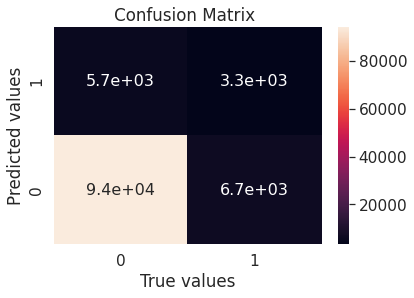

accuracy :  0.887792018907372
error rate :  0.11220798109262797
Sensitivity :  0.33296703296703295
Specificity :  0.94333
AUC :  0.6349966846133087
Evaluation Metrics for testing:
Precision: 0.370
Recall: 0.333
F1 Score: 0.351
Accuracy: 0.877
log likelihood -2.8423110387076114
error rate 0.12344


In [40]:
y_predicted_LoR=discreticize(y_predicted_MC,np.sort(y_predicted_MC)[91000])
logistic_evaluation(y_test,y_predicted_LoR)

##### Balanced

In [41]:
w_init = np.zeros(200)
samplesB_MC =run_sampling(new_X_train,new_Y_train,w_init,1000, step_size=0.002) 
y_predictedB_MC=predict_y_MCMC(new_X_test, samplesB_MC)

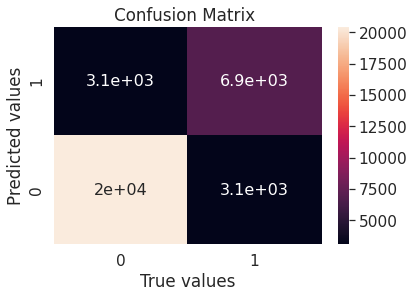

accuracy :  0.815143572024306
error rate :  0.18485642797569402
Sensitivity :  0.6893705876503927
Specificity :  0.868934722517542
AUC :  0.7301809098156853
Evaluation Metrics for testing:
Precision: 0.692
Recall: 0.689
F1 Score: 0.691
Accuracy: 0.736
log likelihood -6.076905416520752
error rate 0.26391664894748035


In [42]:
y_predictedB_LoR = discreticize(y_predictedB_MC,np.sort(y_predictedB_MC)[13500])
logistic_evaluation(new_Y_test,y_predictedB_LoR)

#### Prediction Using Variational Inference

In [43]:
#Using Variational Inference
def predict_y_VI(sample_fn, q_params, Xt, rng, Nmc=10):
    """Compute the outputs of the model by sampling the posterior,
    then take the expectation
    """

    def predict_y_single(rng):
        w = sample_fn(rng,q_params)# @@ COMPLETE @@ #
        yp = model(w,Xt)# @@ COMPLETE @@ #
        return yp

    rng = jax.random.split(rng, Nmc)
    Xt = jnp.atleast_1d(Xt)
    yp = jax.vmap(predict_y_single)(rng)
    # Take the mean
    yp_mean = jnp.mean(yp,axis=0)# @@ COMPLETE @@ #
    return yp,yp_mean


##### Imbalanced

In [44]:
rng = jax.random.PRNGKey(0)
p_params =GaussianDiagonal(jnp.zeros(200),jnp.zeros(200)) # @@ COMPLETE @@ #
q_params=p_params
elbo_fn = create_elbo_fn(
    sample_fn=sample_gaussian_diagonal,# @@ COMPLETE @@ #
    kl_divergence_fn=kl_diag_diag,# @@ COMPLETE @@ #
    likelihood_fn=bernoulli_density# @@ COMPLETE @@ #
)


elbo_summary = []
lik_summary = []
kl_summary = []

for i in tqdm(range(500), desc="Training ELBO"):
    rng, rng2 = jax.random.split(rng)
    q_params_grad, (likelihood, kl) = grad_elbo_fn(q_params,p_params, rng2, X_train, y_train, Nmc=400)# @@ COMPLETE @@ #
    q_params = sg_update(q_params,q_params_grad,1e-6)# @@ COMPLETE @@ #
    lik_summary.append(likelihood)
    kl_summary.append(kl)
    elbo_summary.append(likelihood - kl)


print("Converged posterior")
print("Mean =", q_params.mean)
print("Var =", np.exp(q_params.log_var))

yp,y_predicted_VI = predict_y_VI(sample_gaussian_diagonal, q_params, X_test, rng, Nmc=400)
print("predicted labels: ", y_predicted_VI)
print("likelihood summary: ", lik_summary)
print("kl divergence summary: ", kl_summary)
print("elbo summary: ", elbo_summary)

Training ELBO:   0%|          | 0/500 [00:00<?, ?it/s]

Converged posterior
Mean = [ 0.10699745  0.10067371  0.10978868  0.01392687  0.04071299  0.06479366
  0.12931854 -0.00425425  0.02360294 -0.08342639  0.00278359  0.04186825
 -0.15384819 -0.11261722 -0.01400077  0.04230103  0.00237547  0.0057384
  0.08582708  0.01906004 -0.04443105 -0.13569094  0.11857145 -0.0583928
  0.06370739  0.02343228  0.12778436 -0.00018517 -0.05666898  0.01097568
  0.00971109 -0.05682854  0.07252055 -0.09824989 -0.10704671  0.08587734
 -0.07464393  0.01563313 -0.00114966 -0.00752714  0.11042397  0.00360156
 -0.01985027 -0.05324141 -0.10000924 -0.04495885  0.02238281  0.02500099
  0.06506279  0.06248463 -0.02633444  0.04922353  0.06610466  0.13821357
 -0.03524227  0.03566454 -0.06852064 -0.03733109 -0.06129564 -0.0180354
  0.02038119  0.01999906  0.02346931 -0.03201988 -0.02739112  0.01835737
  0.04916694  0.10015722 -0.03441143  0.0020042   0.05947842  0.06852406
 -0.03591334 -0.01140392  0.05361446 -0.08134904 -0.1258275  -0.03867935
  0.10259756  0.01140703 -0

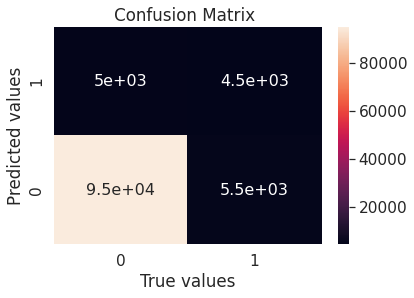

accuracy :  0.9051177165712208
error rate :  0.09488228342877925
Sensitivity :  0.45314685314685316
Specificity :  0.95036
AUC :  0.6989925842576138
Evaluation Metrics for testing:
Precision: 0.477
Recall: 0.453
F1 Score: 0.465
Accuracy: 0.896
log likelihood -2.4034383199817744
error rate 0.10438000000000003


In [45]:
y_predicted_VI = discreticize(y_predicted_VI,np.sort(y_predicted_VI)[90500])
logistic_evaluation(y_test,y_predicted_VI)

##### Balanced

In [46]:
rng = jax.random.PRNGKey(0)
p_params =GaussianDiagonal(jnp.zeros(200),jnp.zeros(200)) # @@ COMPLETE @@ #
q_params=p_params
elbo_fn = create_elbo_fn(
    sample_fn=sample_gaussian_diagonal,# @@ COMPLETE @@ #
    kl_divergence_fn=kl_diag_diag,# @@ COMPLETE @@ #
    likelihood_fn=bernoulli_density# @@ COMPLETE @@ #
)


elbo_summary = []
lik_summary = []
kl_summary = []

for i in tqdm(range(500), desc="Training ELBO"):
    rng, rng2 = jax.random.split(rng)
    q_params_grad, (likelihood, kl) = grad_elbo_fn(q_params,p_params, rng2, new_X_train, new_Y_train, Nmc=400)# @@ COMPLETE @@ #
    q_params = sg_update(q_params,q_params_grad,1e-6)# @@ COMPLETE @@ #
    lik_summary.append(likelihood)
    kl_summary.append(kl)
    elbo_summary.append(likelihood - kl)


print("Converged posterior")
print("Mean =", q_params.mean)
print("Var =", np.exp(q_params.log_var))

yp,y_predictedB_VI = predict_y_VI(sample_gaussian_diagonal, q_params, new_X_test, rng, Nmc=400)
print("predicted labels: ", y_predictedB_VI)
print("likelihood summary: ", lik_summary)
print("kl divergence summary: ", kl_summary)
print("elbo summary: ", elbo_summary)

Training ELBO:   0%|          | 0/500 [00:00<?, ?it/s]

Converged posterior
Mean = [ 3.86819810e-01  3.31301302e-01  3.72458607e-01  1.54828161e-01
  8.25868770e-02  2.38579184e-01  4.60140854e-01 -6.59977198e-02
  1.31067649e-01 -2.93638378e-01 -1.89938527e-02  1.93430722e-01
 -4.81897473e-01 -4.25479144e-01 -3.48181166e-02  1.62434846e-01
  4.73288819e-02 -2.64591221e-02  3.35788995e-01  1.15262039e-01
 -1.60569608e-01 -3.80934745e-01  4.23255622e-01 -2.52314091e-01
  1.70940518e-01 -1.29825459e-03  4.85917151e-01 -4.12544352e-04
 -2.39053726e-01  3.24972123e-02  1.92293860e-02 -2.79235542e-01
  2.07813621e-01 -3.45115751e-01 -3.35239261e-01  3.10059249e-01
 -2.85878688e-01  5.16226292e-02 -9.01951548e-03  9.92525220e-02
  3.78924012e-01 -5.38198417e-03  9.80509818e-03 -2.28877962e-01
 -3.32736999e-01 -1.73829943e-01  6.40671328e-02  8.19694325e-02
  2.49715507e-01  2.05875739e-01 -4.73541580e-02  1.87164694e-01
  2.70316571e-01  5.12640357e-01 -1.88546106e-01  1.48777589e-01
 -3.25812846e-01 -6.00793250e-02 -1.38364062e-01 -5.55655472e-0

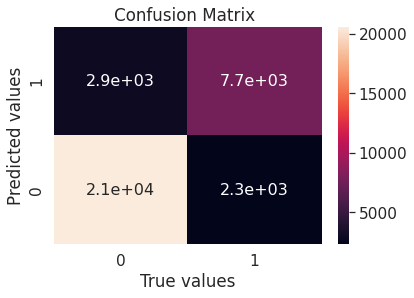

accuracy :  0.8434409627070177
error rate :  0.15655903729298226
Sensitivity :  0.7685194391965795
Specificity :  0.8754837337869446
AUC :  0.7754768395269568
Evaluation Metrics for testing:
Precision: 0.725
Recall: 0.769
F1 Score: 0.746
Accuracy: 0.776
log likelihood -5.146666914136929
error rate 0.22351690410376357


In [47]:
y_predictedB_VI = discreticize(y_predictedB_VI,np.sort(y_predictedB_MC)[13500])
logistic_evaluation(new_Y_test,y_predictedB_VI)

The choice of hyperparameters of variational inference algorithm is too critical. By setting 1e-7 as a learning rate, initializing the prior and posterior parameters by only 1 and choosing 100 MC samples, the model just learned to predict 1 every time with same variance and mean. By increasing the number of MC samples and initializing the prior and posterior parameters with 0, the model doesn't converge and give NaN values for the converged posterior parameters.

### D. (text) Comment on the tuning of the Metropolis-Hastings algorithm, and how to guarantee that samples are representative of samples of the posterior over model parameters. [5]

Tuning this algorithm is very complicated. It takes into account: 
 
 - The number of weights sampled to make predictions,  step size  (to sample new weights vector). In fact, a small step size seems to allow us to add new weights more often (acceptance rate around 90), but a large step size, is less likely to accept the weights of the new sample and keep the same weights. This has to do with the possibility of getting a small likelihood. In fact, the step size affects the output error rate. We need to make it low enough to ensure to convergence and avoid divergence, and also high enough to converge quickly.


 - The starting point which has a huge impact on the weights sampled. I tried 2 different starting points: the null one, the one initialized by 1. The null w_init was the one that gave better results (the one initialized with 1 predict 1 for all input points) with a 10000 samples.

To guarantee that samples are representative of the posterior over model parameters we could run multiple iterations of MH on different independent chains and verify that it converges each time. I used the burn-in trick we did in the lab. Due to the high dimensionality, I didn't visualize the path of the chains to ensure the representativity of samples. A solution to this problem is to print the rhats score instead.

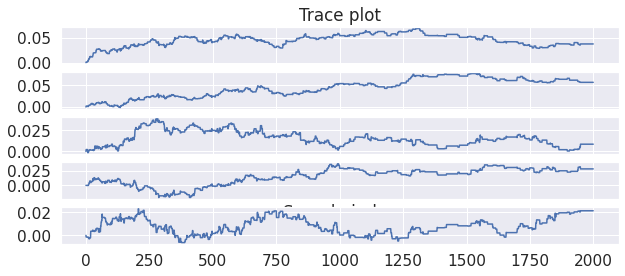

In [48]:
w_init = np.zeros(200)
samples = run_sampling(X_train,y_train,w=w_init, n_samples=2000,  step_size=0.002)
fig, (ax0, ax1,ax2,ax3,ax4) = plt.subplots(5, 1, figsize=[10, 4], sharex=True)
ax0.plot(list(range(0, samples.shape[0])), samples[:, 1])
ax1.plot(list(range(0, samples.shape[0])), samples[:, 2])
ax2.plot(list(range(0, samples.shape[0])), samples[:, 3])
ax3.plot(list(range(0, samples.shape[0])), samples[:, 4])
ax4.plot(list(range(0, samples.shape[0])), samples[:, 5])
ax0.set_title("Trace plot")
ax3.set_xlabel(r"Sample index")
plt.show()

### E. (text) Comment on the tuning of the variational inference algorithm, and discuss the behavior of the optimization with respect to the choice of the optimizer/step-size. [5]


With large datasets, the evaluation of the likelihood  NMC  times can be computationally challenging. To address this problem we can approximate the ELBO by using a mini-batching. 
However, In my notebook, I didn't implement this extension of the ELBO I used the one we implemented during the labs and I used a low value for the number of MC samples. 
As mentioned in the lab, reducing the number of MC samples allow to scale the Variational Inference method on a large dataset. 

During the lab, we updated the posterior parameters by using SGD. I used the same optimizer in the variational inference part. Unlike Adam, SGD optimizer has fixed learning rate, so once again we need to carefully and appropriately set the learning rate. From my implementations, the learning hould be very low in order to avoid the NaN values for the converged posterior parameters. At the same time, it should be high enough to ensure reasonable training time. Overall, I chosed 1e-10 as the learning rate for the run with null parameters and 1e-7 in the other setting. The NaN values were probably obtained du to a gradient explosion problems. 

Moreover, variational inference part can be ameliorated by using other distributions rather than the simplest and diagonal one.

### F. (text) Report the error metrics implemented in point 2.B. above and the confusion matrix on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression. [5]

#### Error rate comparison

From the error rates we obtained for different models (printed in the previous questions), we observe that the bayesian linear regression applied on the given dataset scaled has the lowest error rate. By considering also the training time spent for each model, it seems that bayesian linear regression outperformed the logistic regression models.

#### Log likelihood comparison
By comparing the Metropolis Hasting and Variational Inference algorithms in terms of log likelihood, it seems that the Variational Inference approximation is better. It has the highest log likelihood with prediction on the given dataset scaled.


Overall the performance results obtained shows that making prediction by using the given dataset without balancing is better.


With sufficient time training, appropriate feature preprocessing, and better hyperparameters tuning, the logistic regression should overperform the bayesian linear model because it takes into account also the non-linearities. This  will help to find patterns in a given dataset. 
However, regarding the dataset we have, the result we obtained for logistic regression doesn't met this expectation and this is due to the bad hyperparameters tuning I used. 


### G. (text) Compare the uncertainties on predictions obtained by the Metropolis-Hastings algorithm and variational inference. First, compare the log-likelihood on test data as aglobal metric to assess which inference method yields better uncertainty quantification. Second, pick a few test points for which the mean of the predictive distribution for Metropolis-Hastings is (a) around 0.5 (b) giving a correct prediction (c) giving a wrong prediction, and visualize/discuss what the predictive distribution looks like. Discuss the difference between the Metropolis-Hastings algorithm and variational inference. [15]

### (a).

[]

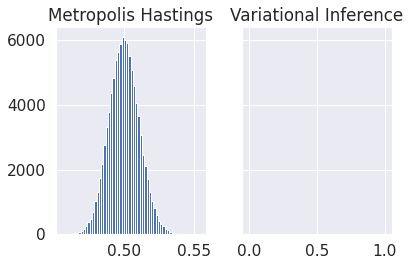

In [49]:
prediction_05_MC = [y for y in y_predicted_MC if 0.4 < y < 0.6]
prediction_05_VI = [y for y in y_predicted_VI if 0.4 < y < 0.6]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(prediction_05_MC, bins=60)
axs[0].title.set_text('Metropolis Hastings')
axs[1].hist(prediction_05_VI, bins=60)
axs[1].title.set_text('Variational Inference')
plt.plot()

#### (b).

[]

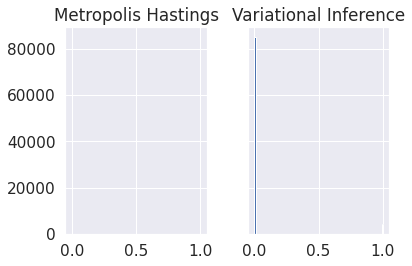

In [50]:
correct_prediction_MC = [y_predicted_MC[i] for i in range(len(y_predicted_MC)) if y_predicted_MC[i] == y_test[i]]
correct_prediction_VI = [y_predicted_VI[i] for i in range(len(y_predicted_VI)) if y_predicted_VI[i] == y_test[i]]

n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].title.set_text('Metropolis Hastings')
axs[0].hist(correct_prediction_MC, bins=n_bins)
axs[1].title.set_text('Variational Inference')
axs[1].hist(correct_prediction_VI, bins=n_bins)
plt.plot()

[]

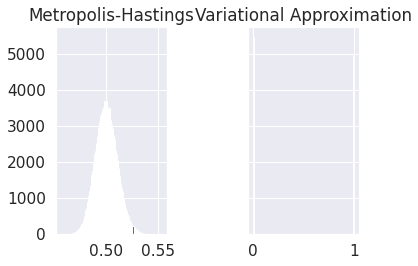

In [51]:
incorrect_prediction_MC = [y_predicted_MC[i] for i in range(len(y_predicted_MC)) if y_predicted_MC[i] != y_test[i]]
incorrect_prediction_VI = [y_predicted_VI[i] for i in range(len(y_predicted_VI)) if y_predicted_VI[i] != y_test[i]]


n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].title.set_text('Metropolis-Hastings')
axs[0].hist(incorrect_prediction_MC, bins=n_bins)
axs[1].title.set_text('Variational Approximation')
axs[1].hist(incorrect_prediction_VI, bins=n_bins)
plt.plot()

From the confusion matrix we obtained with Metropolis Hasting , we can see that it doesn't predict 1 or 0 to every input, thing that variational inference unfortunately does. This could be explained the random sampling way of Metropolis Hasting that helps to look more for weights, and therefore not fall in the trap of predicting "0" or "1" everytime depending on W_init. Furthermore, the gaussian diagonal distribution used is too simple and hence yields to poor generalization (predicting 1 all the time).

To conclude, Metropolis Hasting has better performance than Variational inference on my settings. 

# 3. Bonus questions

### A. (code/text) Implement the Laplace approximation and compare the predictive mean and variances with the ones obtained by the other approximations.

In [52]:
def laplace(w, w_map, H):
    detH =  np.linalg.det(H)
    constant = np.sqrt(detH)/(2*np.pi)**(2.0/2.0)
    density = np.exp(-0.5 * (w-w_map).dot(H).dot(w-w_map))
    return constant * density

### B. (code/text) Suggest and implement ways to improve performance.

To improve the performance for the bayesian models we need to care more much about the initialization and the hyperparameters tuning part.
